In [2]:
!pip install pandas scipy numpy matplotlib seaborn

   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.3 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/11.3 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.3 MB 3.2 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.3 MB 3.0 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.3 MB 2.6 MB/s eta 0:00:04
   ---------- ----------------------------- 2.9/11.3 MB 2.5 MB/s eta 0:00:04
   ------------ --------------------------- 3.4/11.3 MB 2.4 MB/s eta 0:00:04
   ------------- -------------------------- 3.9/11.3 MB 2.3 MB/s eta 0:00:04
   --------------- ------------------------ 4.5/11.3 MB 2.3 MB/s eta 0:00:03
   ---------------- ----------------------- 4.7/11.3 MB 2.3 MB/s eta 0:00:03
   ------------------ --------------------- 5.2/11.3 MB 2.3 MB/s eta 0:00:03
   ------------------- -------------------- 5.5/11.3 MB 2.3 MB/s eta 0:00:03
   ---

In [3]:
import pandas as pd 

In [5]:
df = pd.read_csv('simulated_abtest_data.csv')
df.head()

,date_key,user_id,variant,total_session_page,total_click_page,total_paid_order,total_paid_amount
0,2024-01-08,user_1001,control,3,1,0,0
1,2024-01-08,user_1002,treatment,2,2,1,125000
2,2024-01-08,user_1003,control,1,0,0,0
3,2024-01-08,user_1004,treatment,4,3,1,89000
4,2024-01-08,user_1005,control,2,1,0,0


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [6]:
df.groupby('variant').agg({
    'total_session_page':sum,
    'total_click_page':sum,
    'total_paid_order':sum,
    'total_paid_amount':sum
})

C:\Users\dimas\AppData\Local\Temp\ipykernel_9604\134031976.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.groupby('variant').agg({
C:\Users\dimas\AppData\Local\Temp\ipykernel_9604\134031976.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.groupby('variant').agg({


,total_session_page,total_click_page,total_paid_order,total_paid_amount
variant,,,,
control,204,94,21,2863000
treatment,365,291,127,21879000


In [8]:
# Calculate daily metrics by variant
daily_metrics = df.groupby(['date_key', 'variant']).agg({
    'total_session_page': 'sum',
    'total_click_page': 'sum', 
    'total_paid_order': 'sum',
    'total_paid_amount': 'sum'
}).reset_index()

print("Daily metrics by variant:")
print(daily_metrics.head(10))


Daily metrics by variant:
     date_key    variant  total_session_page  total_click_page  \
0  2024-01-08    control                  20                 8   
1  2024-01-08  treatment                  24                20   
2  2024-01-09    control                  22                 9   
3  2024-01-09  treatment                  27                22   
4  2024-01-10    control                  26                13   
5  2024-01-10  treatment                  40                31   
6  2024-01-11    control                  29                13   
7  2024-01-11  treatment                  51                41   
8  2024-01-12    control                  32                15   
9  2024-01-12  treatment                  65                52   

   total_paid_order  total_paid_amount  
0                 2             234000  
1                10            1316000  
2                 2             223000  
3                 8            1203000  
4                 2             265000  
5

In [9]:
# Pivot data to have control and treatment as columns
daily_pivot = daily_metrics.pivot(index='date_key', columns='variant', values=[
    'total_session_page', 'total_click_page', 'total_paid_order', 'total_paid_amount'
])

# Calculate daily differences (treatment - control)
differences = pd.DataFrame({
    'date_key': daily_pivot.index,
    'session_diff': daily_pivot[('total_session_page', 'treatment')] - daily_pivot[('total_session_page', 'control')],
    'click_diff': daily_pivot[('total_click_page', 'treatment')] - daily_pivot[('total_click_page', 'control')],
    'order_diff': daily_pivot[('total_paid_order', 'treatment')] - daily_pivot[('total_paid_order', 'control')],
    'amount_diff': (daily_pivot[('total_paid_amount', 'treatment')] - daily_pivot[('total_paid_amount', 'control')]) / 1000  # Convert to thousands
})

print("Daily differences (Treatment - Control):")
print(differences)


Daily differences (Treatment - Control):
              date_key  session_diff  click_diff  order_diff  amount_diff
date_key                                                                 
2024-01-08  2024-01-08             4          12           8       1082.0
2024-01-09  2024-01-09             5          13           6        980.0
2024-01-10  2024-01-10            14          18          10       1628.0
2024-01-11  2024-01-11            22          28          14       2445.0
2024-01-12  2024-01-12            33          37          20       3621.0
2024-01-13  2024-01-13            35          38          21       4059.0
2024-01-14  2024-01-14            48          51          27       5201.0


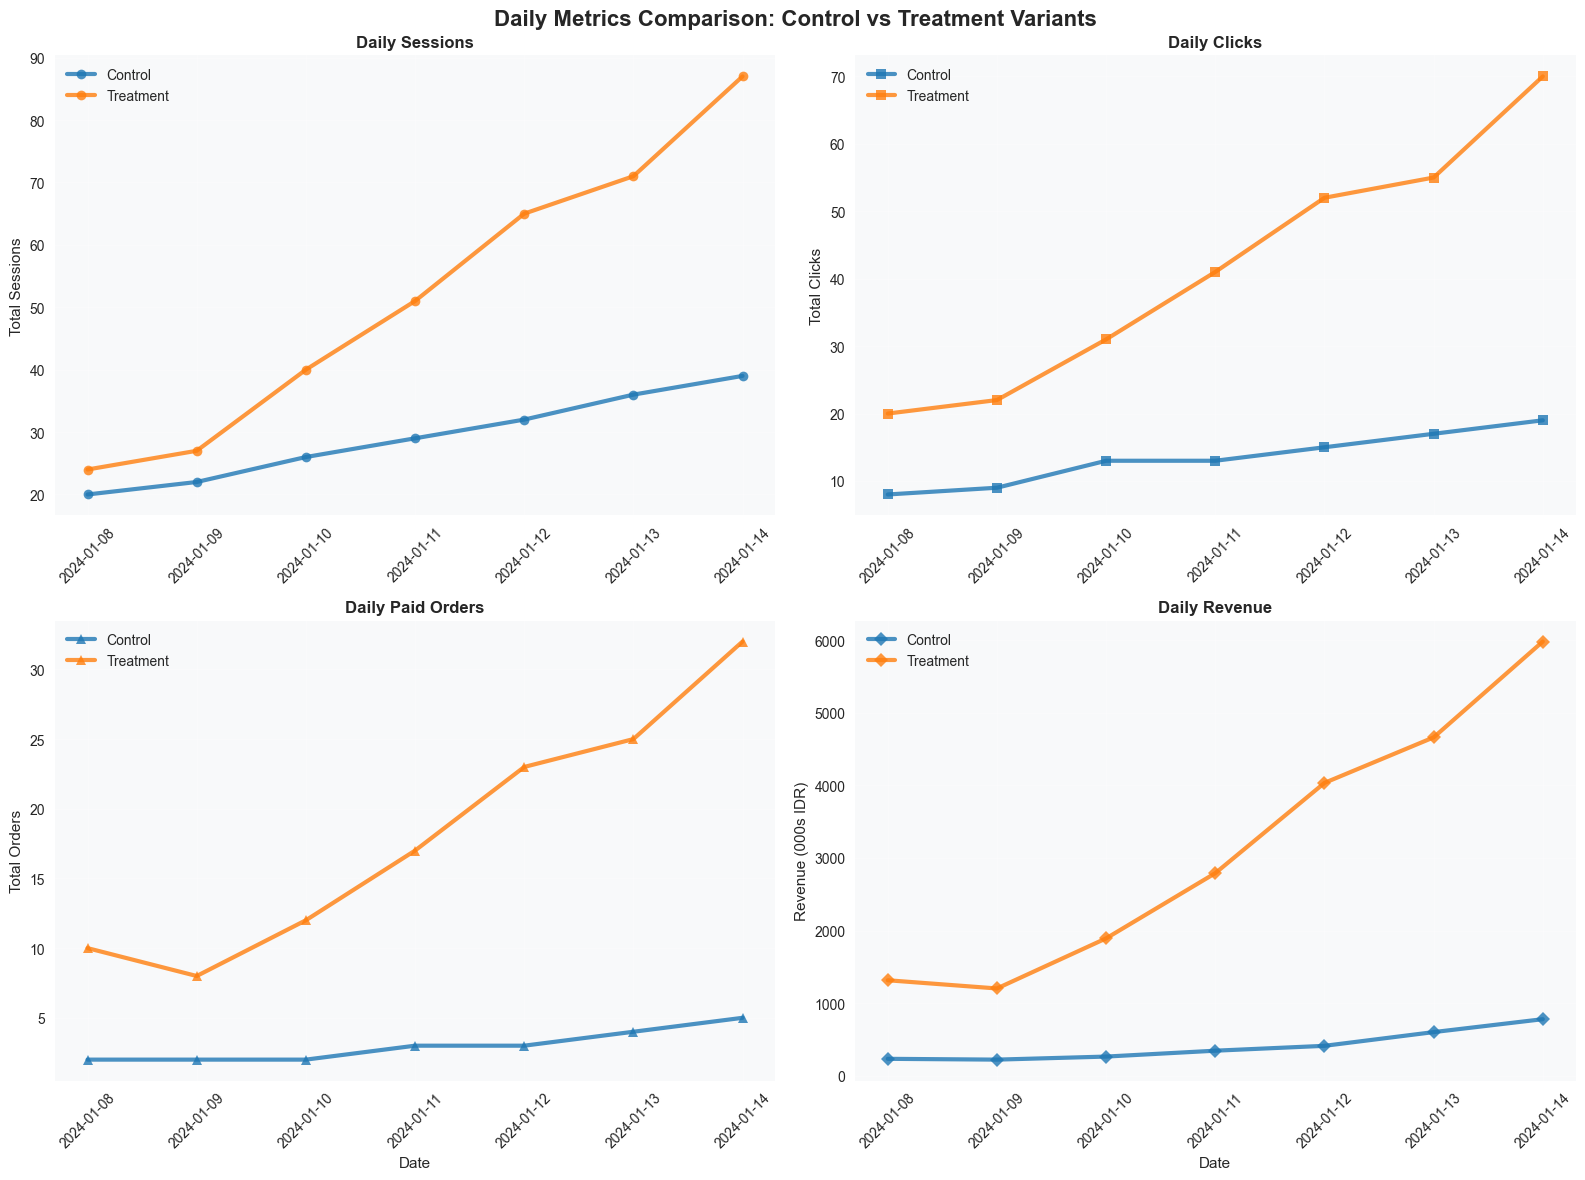

In [12]:
# Prepare data for plotting - separate control and treatment
daily_pivot_reset = daily_pivot.reset_index()
daily_pivot_reset['date_key'] = pd.to_datetime(daily_pivot_reset['date_key'])

# Create line chart showing control vs treatment for each metric
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Daily Metrics Comparison: Control vs Treatment Variants', 
             fontsize=16, fontweight='bold')

# Sessions
ax1.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_session_page', 'control')], 
         marker='o', linewidth=3, markersize=7, label='Control', color='#1f77b4', alpha=0.8)
ax1.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_session_page', 'treatment')], 
         marker='o', linewidth=3, markersize=7, label='Treatment', color='#ff7f0e', alpha=0.8)
ax1.set_title('Daily Sessions', fontweight='bold', fontsize=12)
ax1.set_ylabel('Total Sessions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Clicks
ax2.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_click_page', 'control')], 
         marker='s', linewidth=3, markersize=7, label='Control', color='#1f77b4', alpha=0.8)
ax2.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_click_page', 'treatment')], 
         marker='s', linewidth=3, markersize=7, label='Treatment', color='#ff7f0e', alpha=0.8)
ax2.set_title('Daily Clicks', fontweight='bold', fontsize=12)
ax2.set_ylabel('Total Clicks')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Orders
ax3.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_paid_order', 'control')], 
         marker='^', linewidth=3, markersize=7, label='Control', color='#1f77b4', alpha=0.8)
ax3.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_paid_order', 'treatment')], 
         marker='^', linewidth=3, markersize=7, label='Treatment', color='#ff7f0e', alpha=0.8)
ax3.set_title('Daily Paid Orders', fontweight='bold', fontsize=12)
ax3.set_ylabel('Total Orders')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Revenue (in thousands)
ax4.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_paid_amount', 'control')] / 1000, 
         marker='D', linewidth=3, markersize=7, label='Control', color='#1f77b4', alpha=0.8)
ax4.plot(daily_pivot_reset['date_key'], daily_pivot_reset[('total_paid_amount', 'treatment')] / 1000, 
         marker='D', linewidth=3, markersize=7, label='Treatment', color='#ff7f0e', alpha=0.8)
ax4.set_title('Daily Revenue', fontweight='bold', fontsize=12)
ax4.set_ylabel('Revenue (000s IDR)')
ax4.set_xlabel('Date')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)
    ax.set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()


In [14]:
# Summary statistics of daily differences
print("Summary Statistics of Daily Differences (Treatment - Control):")
print("=" * 60)
print(f"Sessions - Mean: {differences['session_diff'].mean():.2f}, Std: {differences['session_diff'].std():.2f}")
print(f"Clicks - Mean: {differences['click_diff'].mean():.2f}, Std: {differences['click_diff'].std():.2f}")
print(f"Orders - Mean: {differences['order_diff'].mean():.2f}, Std: {differences['order_diff'].std():.2f}")
print(f"Revenue (000s IDR) - Mean: {differences['amount_diff'].mean():.2f}, Std: {differences['amount_diff'].std():.2f}")

print(f"\nTotal Cumulative Differences over {len(differences)} days:")
print("=" * 50)
print(f"Sessions: +{differences['session_diff'].sum():,.0f}")
print(f"Clicks: +{differences['click_diff'].sum():,.0f}")
print(f"Orders: +{differences['order_diff'].sum():,.0f}")
print(f"Revenue: +{differences['amount_diff'].sum():,.0f}k IDR (+{differences['amount_diff'].sum()*1000:,.0f} IDR)")


Summary Statistics of Daily Differences (Treatment - Control):
Sessions - Mean: 23.00, Std: 16.51
Clicks - Mean: 28.14, Std: 14.67
Orders - Mean: 15.14, Std: 7.76
Revenue (000s IDR) - Mean: 2716.57, Std: 1619.61

Total Cumulative Differences over 7 days:
Sessions: +161
Clicks: +197
Orders: +106
Revenue: +19,016k IDR (+19,016,000 IDR)


In [15]:
import scipy.stats as stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

print("Statistical Analysis: CTR, CVR, and TIV Comparison")
print("=" * 60)


Statistical Analysis: CTR, CVR, and TIV Comparison


In [16]:
# Step 1: Aggregate data to user level
user_level_data = df.groupby(['user_id', 'variant']).agg({
    'total_session_page': 'sum',
    'total_click_page': 'sum', 
    'total_paid_order': 'sum',
    'total_paid_amount': 'sum'
}).reset_index()

# Calculate user-level metrics
user_level_data['CTR'] = user_level_data['total_click_page'] / user_level_data['total_session_page']
user_level_data['CVR'] = user_level_data['total_paid_order'] / user_level_data['total_session_page']
user_level_data['TIV'] = user_level_data['total_paid_amount'] / 1  # Total Individual Value per user

# Handle division by zero (users with 0 sessions)
user_level_data['CTR'] = user_level_data['CTR'].fillna(0)
user_level_data['CVR'] = user_level_data['CVR'].fillna(0)

print("User-level data sample:")
print(user_level_data.head(10))
print(f"\nTotal users: {len(user_level_data)}")
print(f"Control users: {len(user_level_data[user_level_data['variant'] == 'control'])}")
print(f"Treatment users: {len(user_level_data[user_level_data['variant'] == 'treatment'])}")


User-level data sample:
     user_id    variant  total_session_page  total_click_page  \
0  user_1001    control                  14                 6   
1  user_1002  treatment                  20                15   
2  user_1003    control                  10                 3   
3  user_1004  treatment                  19                14   
4  user_1005    control                  16                10   
5  user_1006    control                  18                10   
6  user_1007  treatment                  30                25   
7  user_1008    control                  12                 4   
8  user_1009  treatment                  22                19   
9  user_1010    control                  12                 4   

   total_paid_order  total_paid_amount       CTR       CVR        TIV  
0                 1             134000  0.428571  0.071429   134000.0  
1                 4             671000  0.750000  0.200000   671000.0  
2                 0                  0  0.30

In [17]:
# Step 2: Separate control and treatment groups
control_data = user_level_data[user_level_data['variant'] == 'control']
treatment_data = user_level_data[user_level_data['variant'] == 'treatment']

# Summary statistics by variant
print("\nSummary Statistics by Variant:")
print("=" * 40)

summary_stats = user_level_data.groupby('variant')[['CTR', 'CVR', 'TIV']].agg(['count', 'mean', 'std', 'min', 'max'])
print(summary_stats.round(4))



Summary Statistics by Variant:
            CTR                                   CVR                       \
          count    mean     std     min     max count    mean     std  min   
variant                                                                      
control      23  0.4768  0.2521  0.0000  1.0000    23  0.1091  0.1254  0.0   
treatment    22  0.7820  0.0792  0.6154  0.8889    22  0.3274  0.1153  0.0   

                 TIV                                            
           max count         mean          std  min        max  
variant                                                         
control    0.5    23  124478.2609  142570.8339  0.0   501000.0  
treatment  0.5    22  994500.0000  631364.7161  0.0  2656000.0  


In [18]:
# Step 3: Delta Method for Ratio Metrics (CTR and CVR)
def delta_method_ratio_variance(numerator_data, denominator_data):
    """
    Calculate variance of ratio metric using delta method
    Var(X/Y) ≈ (μ_x/μ_y)² * [(σ_x²/μ_x²) + (σ_y²/μ_y²) - 2*ρ*σ_x*σ_y/(μ_x*μ_y)]
    where ρ is correlation between numerator and denominator
    """
    n = len(numerator_data)
    
    # Sample means
    mu_x = np.mean(numerator_data)
    mu_y = np.mean(denominator_data)
    
    # Sample variances
    var_x = np.var(numerator_data, ddof=1)
    var_y = np.var(denominator_data, ddof=1)
    
    # Sample correlation
    correlation = np.corrcoef(numerator_data, denominator_data)[0, 1]
    
    # Delta method variance approximation
    if mu_y == 0:
        return 0, 0, n
    
    ratio_mean = mu_x / mu_y
    
    # Variance formula for ratio
    variance_ratio = (ratio_mean**2) * (
        (var_x / mu_x**2) + (var_y / mu_y**2) - 
        (2 * correlation * np.sqrt(var_x * var_y) / (mu_x * mu_y))
    ) / n
    
    return ratio_mean, variance_ratio, n

print("Delta Method Variance Estimation:")
print("=" * 40)


Delta Method Variance Estimation:


In [19]:
# Calculate metrics for each variant using delta method

# CTR Analysis
print("1. CTR (Click-Through Rate) Analysis:")
print("-" * 35)

# Control CTR
ctr_control_mean, ctr_control_var, n_control = delta_method_ratio_variance(
    control_data['total_click_page'].values, 
    control_data['total_session_page'].values
)

# Treatment CTR  
ctr_treatment_mean, ctr_treatment_var, n_treatment = delta_method_ratio_variance(
    treatment_data['total_click_page'].values, 
    treatment_data['total_session_page'].values
)

print(f"Control CTR: {ctr_control_mean:.4f} ± {np.sqrt(ctr_control_var):.4f} (n={n_control})")
print(f"Treatment CTR: {ctr_treatment_mean:.4f} ± {np.sqrt(ctr_treatment_var):.4f} (n={n_treatment})")

# Difference and statistical test
ctr_diff = ctr_treatment_mean - ctr_control_mean
ctr_diff_se = np.sqrt(ctr_control_var + ctr_treatment_var)
ctr_z_score = ctr_diff / ctr_diff_se if ctr_diff_se > 0 else 0
ctr_p_value = 2 * (1 - norm.cdf(abs(ctr_z_score)))

print(f"CTR Difference: {ctr_diff:.4f} ± {ctr_diff_se:.4f}")
print(f"Z-score: {ctr_z_score:.4f}")
print(f"P-value: {ctr_p_value:.4f}")
print(f"Statistically significant at α=0.05: {'Yes' if ctr_p_value < 0.05 else 'No'}")
print(f"Relative improvement: {(ctr_diff/ctr_control_mean*100):.2f}%" if ctr_control_mean > 0 else "N/A")


1. CTR (Click-Through Rate) Analysis:
-----------------------------------
Control CTR: 0.4608 ± 0.0320 (n=23)
Treatment CTR: 0.7973 ± 0.0159 (n=22)
CTR Difference: 0.3365 ± 0.0357
Z-score: 9.4224
P-value: 0.0000
Statistically significant at α=0.05: Yes
Relative improvement: 73.02%


In [20]:
# CVR Analysis
print("\n2. CVR (Conversion Rate) Analysis:")
print("-" * 35)

# Control CVR
cvr_control_mean, cvr_control_var, _ = delta_method_ratio_variance(
    control_data['total_paid_order'].values, 
    control_data['total_session_page'].values
)

# Treatment CVR
cvr_treatment_mean, cvr_treatment_var, _ = delta_method_ratio_variance(
    treatment_data['total_paid_order'].values, 
    treatment_data['total_session_page'].values
)

print(f"Control CVR: {cvr_control_mean:.4f} ± {np.sqrt(cvr_control_var):.4f}")
print(f"Treatment CVR: {cvr_treatment_mean:.4f} ± {np.sqrt(cvr_treatment_var):.4f}")

# Difference and statistical test
cvr_diff = cvr_treatment_mean - cvr_control_mean
cvr_diff_se = np.sqrt(cvr_control_var + cvr_treatment_var)
cvr_z_score = cvr_diff / cvr_diff_se if cvr_diff_se > 0 else 0
cvr_p_value = 2 * (1 - norm.cdf(abs(cvr_z_score)))

print(f"CVR Difference: {cvr_diff:.4f} ± {cvr_diff_se:.4f}")
print(f"Z-score: {cvr_z_score:.4f}")
print(f"P-value: {cvr_p_value:.4f}")
print(f"Statistically significant at α=0.05: {'Yes' if cvr_p_value < 0.05 else 'No'}")
print(f"Relative improvement: {(cvr_diff/cvr_control_mean*100):.2f}%" if cvr_control_mean > 0 else "N/A")



2. CVR (Conversion Rate) Analysis:
-----------------------------------
Control CVR: 0.1029 ± 0.0179
Treatment CVR: 0.3479 ± 0.0212
CVR Difference: 0.2450 ± 0.0278
Z-score: 8.8222
P-value: 0.0000
Statistically significant at α=0.05: Yes
Relative improvement: 238.00%


In [21]:
# TIV Analysis (Simple mean comparison - not a ratio metric)
print("\n3. TIV (Total Individual Value) Analysis:")
print("-" * 40)

# Control TIV
tiv_control_mean = np.mean(control_data['TIV'])
tiv_control_var = np.var(control_data['TIV'], ddof=1) / len(control_data)
tiv_control_se = np.sqrt(tiv_control_var)

# Treatment TIV
tiv_treatment_mean = np.mean(treatment_data['TIV'])
tiv_treatment_var = np.var(treatment_data['TIV'], ddof=1) / len(treatment_data)
tiv_treatment_se = np.sqrt(tiv_treatment_var)

print(f"Control TIV: {tiv_control_mean:,.0f} ± {tiv_control_se:,.0f} IDR")
print(f"Treatment TIV: {tiv_treatment_mean:,.0f} ± {tiv_treatment_se:,.0f} IDR")

# Difference and statistical test
tiv_diff = tiv_treatment_mean - tiv_control_mean
tiv_diff_se = np.sqrt(tiv_control_var + tiv_treatment_var)
tiv_z_score = tiv_diff / tiv_diff_se if tiv_diff_se > 0 else 0
tiv_p_value = 2 * (1 - norm.cdf(abs(tiv_z_score)))

print(f"TIV Difference: {tiv_diff:,.0f} ± {tiv_diff_se:,.0f} IDR")
print(f"Z-score: {tiv_z_score:.4f}")
print(f"P-value: {tiv_p_value:.4f}")
print(f"Statistically significant at α=0.05: {'Yes' if tiv_p_value < 0.05 else 'No'}")
print(f"Relative improvement: {(tiv_diff/tiv_control_mean*100):.2f}%" if tiv_control_mean > 0 else "N/A")



3. TIV (Total Individual Value) Analysis:
----------------------------------------
Control TIV: 124,478 ± 29,728 IDR
Treatment TIV: 994,500 ± 134,607 IDR
TIV Difference: 870,022 ± 137,851 IDR
Z-score: 6.3113
P-value: 0.0000
Statistically significant at α=0.05: Yes
Relative improvement: 698.93%


In [22]:
# Create summary table of results
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)

results_summary = pd.DataFrame({
    'Metric': ['CTR (Click-Through Rate)', 'CVR (Conversion Rate)', 'TIV (Total Individual Value)'],
    'Control_Mean': [f"{ctr_control_mean:.4f}", f"{cvr_control_mean:.4f}", f"{tiv_control_mean:,.0f}"],
    'Treatment_Mean': [f"{ctr_treatment_mean:.4f}", f"{cvr_treatment_mean:.4f}", f"{tiv_treatment_mean:,.0f}"],
    'Difference': [f"{ctr_diff:.4f}", f"{cvr_diff:.4f}", f"{tiv_diff:,.0f}"],
    'Relative_Lift_%': [
        f"{(ctr_diff/ctr_control_mean*100):.2f}%" if ctr_control_mean > 0 else "N/A",
        f"{(cvr_diff/cvr_control_mean*100):.2f}%" if cvr_control_mean > 0 else "N/A", 
        f"{(tiv_diff/tiv_control_mean*100):.2f}%" if tiv_control_mean > 0 else "N/A"
    ],
    'Z_Score': [f"{ctr_z_score:.4f}", f"{cvr_z_score:.4f}", f"{tiv_z_score:.4f}"],
    'P_Value': [f"{ctr_p_value:.4f}", f"{cvr_p_value:.4f}", f"{tiv_p_value:.4f}"],
    'Significant': [
        'Yes' if ctr_p_value < 0.05 else 'No',
        'Yes' if cvr_p_value < 0.05 else 'No',
        'Yes' if tiv_p_value < 0.05 else 'No'
    ]
})

print(results_summary.to_string(index=False))

# Confidence intervals (95%)
print(f"\n95% Confidence Intervals:")
print("-" * 30)
ctr_ci_lower = ctr_diff - 1.96 * ctr_diff_se
ctr_ci_upper = ctr_diff + 1.96 * ctr_diff_se
print(f"CTR Difference: [{ctr_ci_lower:.4f}, {ctr_ci_upper:.4f}]")

cvr_ci_lower = cvr_diff - 1.96 * cvr_diff_se  
cvr_ci_upper = cvr_diff + 1.96 * cvr_diff_se
print(f"CVR Difference: [{cvr_ci_lower:.4f}, {cvr_ci_upper:.4f}]")

tiv_ci_lower = tiv_diff - 1.96 * tiv_diff_se
tiv_ci_upper = tiv_diff + 1.96 * tiv_diff_se
print(f"TIV Difference: [{tiv_ci_lower:,.0f}, {tiv_ci_upper:,.0f}] IDR")



EXPERIMENT RESULTS SUMMARY
                      Metric Control_Mean Treatment_Mean Difference Relative_Lift_% Z_Score P_Value Significant
    CTR (Click-Through Rate)       0.4608         0.7973     0.3365          73.02%  9.4224  0.0000         Yes
       CVR (Conversion Rate)       0.1029         0.3479     0.2450         238.00%  8.8222  0.0000         Yes
TIV (Total Individual Value)      124,478        994,500    870,022         698.93%  6.3113  0.0000         Yes

95% Confidence Intervals:
------------------------------
CTR Difference: [0.2665, 0.4065]
CVR Difference: [0.1906, 0.2994]
TIV Difference: [599,834, 1,140,210] IDR
